# Arne report for the all cycles 

In [4]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec
import os

from cycler import cycler
# Color blind safe from here https://sronpersonalpages.nl/~pault/
# tol_bright_colors = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#BBBBBB'][::2]
tol_bright_colors = ['#4477AA', '#228833', '#CCBB44', '#EE6677', '#AA3377']
plt.rc('axes', prop_cycle=cycler('color', tol_bright_colors))

def get_experiment_base_path():
    notebook_dir = Path(os.path.dirname(os.path.abspath("__file__")))
    experiment_base_path = notebook_dir / "../experiments/"
    return experiment_base_path

def get_output_fig_path():
    notebook_dir = Path(os.path.dirname(os.path.abspath("__file__")))
    output_fig_path = notebook_dir / "../figures/"
    return output_fig_path



with open(get_experiment_base_path() / 'paperdraft.json', 'r') as f:
    experiment_dict = json.load(f)

def get_experiment_path(experiment):
    return get_experiment_base_path() / experiment_dict[experiment]['experiment_path']

def get_metrics_dict(experiment):
    with open(get_experiment_path(experiment) / 'ensemble_metrics.json', 'r') as f:
        return json.load(f)
    
def load_config(experiment):
    with open(get_experiment_path(experiment) / 'configuration.json', 'r') as f:
        return json.load(f)

In [2]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import json


import numpy as np
backward_shift = np.array(5396198400000000000, dtype='timedelta64[ns]')

experiment_path = Path('../rapid-geostrophic-reconstruction/figs/')


# Train on all six predict third cycle 
test_predictions_90d = xr.open_dataset(get_experiment_path('030') / 'ensemble_predictions.nc').mean('member')
test_predictions_365d = xr.open_dataset(get_experiment_path('031') / 'ensemble_predictions.nc').mean('member')
test_predictions_1825d = xr.open_dataset(get_experiment_path('032') / 'ensemble_predictions.nc').mean('member')

# test_predictions_90d['time'] = test_predictions_90d.time #+ np.array(5372438400000000000, dtype='timedelta64[ns]')
# test_predictions_365d['time'] = test_predictions_365d.time #+ np.array(5396198400000000000, dtype='timedelta64[ns]')
# test_predictions_1825d['time'] = test_predictions_1825d.time #+ np.array(5522342400000000000, dtype='timedelta64[ns]')
# test_predictions_1825d['time'] = test_predictions_1825d.time + 3* np.timedelta64(1825, 'D')

In [5]:
experiment_id_90d = '030'
experiment_id_365d = '031'
experiment_id_1825d = '032'

config_90d = load_config(experiment_id_90d)
config_365d = load_config(experiment_id_365d)
config_1825d = load_config(experiment_id_1825d)

test_predictions_90d['time'] = test_predictions_90d.time - np.timedelta64(int(config_90d['t_deltas'][1]))
test_predictions_365d['time'] = test_predictions_365d.time - np.timedelta64(int(config_365d['t_deltas'][1]))
test_predictions_1825d['time'] = test_predictions_1825d.time - np.timedelta64(int(config_1825d['t_deltas'][1]))

In [6]:
metrics_90d = get_metrics_dict(experiment_id_90d)
metrics_365d = get_metrics_dict(experiment_id_365d)
metrics_1825d = get_metrics_dict(experiment_id_1825d)

width = .2

def draw_skill_plot(skill, width, ax):

    factor = 1
    if skill in ['R2', 'MAPE']:
        factor = 100


    ax.bar(
        [1,2+(width/2),3+width],
        [
            metrics_90d['original']['mean'][skill]* factor,
            metrics_365d['original']['mean'][skill]* factor,
            metrics_1825d['original']['mean'][skill]* factor,
        ], 
        width=width
    )

    ax.bar(
        [1],
        [
        0
        ],
    )


    ax.bar(
        [2-(width / 2),3- width],
        [
            compute_skill(test_predictions_365d.test_gt_transport, test_predictions_90d_365d.test_predictions)[skill] * factor,
            compute_skill(test_predictions_1825d.test_gt_transport, test_predictions_90d_1825d.test_predictions)[skill] * factor
        ],
        width=width

    )

    ax.bar(
        [3],
        [
            compute_skill(test_predictions_1825d.test_gt_transport, test_predictions_365d_1825d.test_predictions)[skill] * factor
        ],
        width=width
    )
    ax.set_xticks([1,2,3])
    # ax.tick_params(axis='x', labelrotation=45)
    ax.set_xticklabels(['90', '365', '1825'])
    ax.set_xlabel('Days')
    ax.set_ylabel(f'{skill}{" (%)" if skill in ["R2", "MAPE"] else ""}')

    
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
def compute_skill(ground_truth, prediction):

    # time_selected_truth = ground_truth.sel(time = prediction.time, method = "nearest").values
    # prediction = prediction.values

    time_selected_prediction = prediction.values #.sel(time = ground_truth.time, method = "nearest").values
    ground_truth = ground_truth.values
    return {
        'MAE': mean_absolute_error(ground_truth, time_selected_prediction),
        'R2': r2_score(ground_truth, time_selected_prediction),
        'RMSE': root_mean_squared_error(ground_truth, time_selected_prediction),
        'MAPE': mean_absolute_percentage_error(ground_truth, time_selected_prediction)
    }


/tmp/ipykernel_107253/2983123366.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


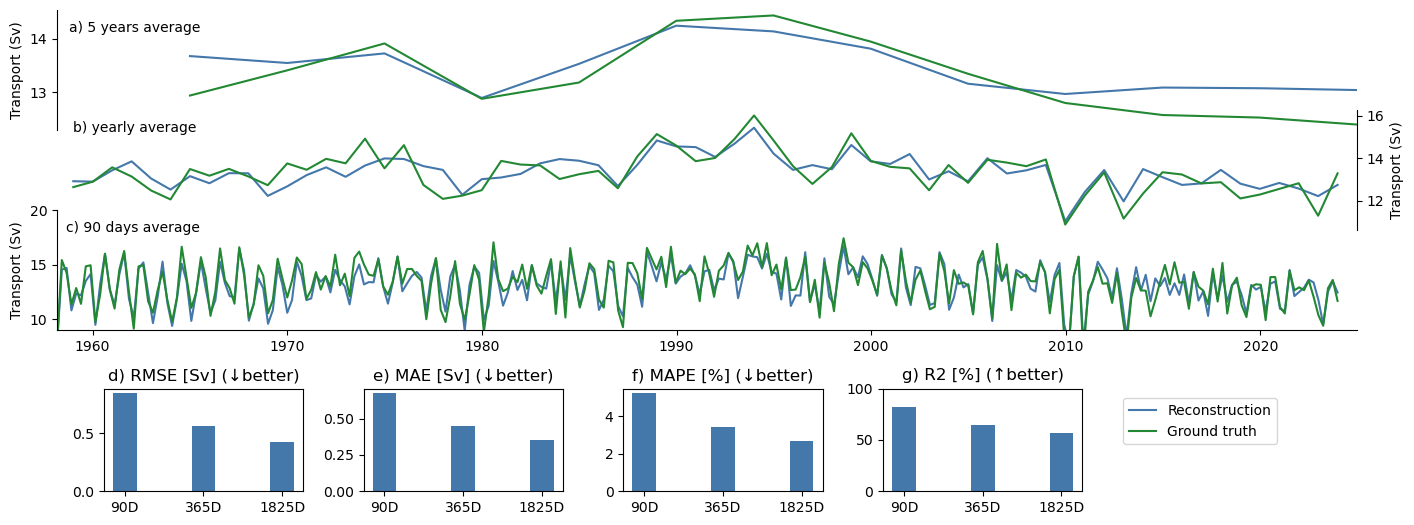

In [7]:
from matplotlib.gridspec import GridSpec

axes_width = 1

label_x = .06
label_y = .85

fig = plt.figure(figsize=(13,5))
label_y = .85

base_height = .4
overlap_percentage = .1
delta = (1 - base_height)


height_per_plot = delta * (1 + 2 * overlap_percentage) / 3


gs = GridSpec(2,5, figure=fig, height_ratios=[3,1])
ax = fig.add_axes([0, base_height + (delta / 3) * 0, 1, height_per_plot])

ax.plot(test_predictions_90d.time, test_predictions_90d.test_predictions, label = 'Reconstruction')
ax.plot(test_predictions_90d.time, test_predictions_90d.test_gt_transport, label='Ground truth')

# remove the x-axis and also the border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# ax.set_xticks([])

ax.set_ylim(9,20)

ax.text(label_x, label_y, f'c) 90 days average ', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.tick_params(labelbottom=True)

ax.set_ylabel('Transport (Sv)')
# ax.set_xlabel('Test cycle no. 3')
ax90 = ax

ax = fig.add_axes([0, base_height + (delta / 3) * 1, 1, height_per_plot])


smoothing_days = 365
# test_predictions_90d_365d = test_predictions_90d.resample(time=f'{smoothing_days}D').mean()
test_predictions_90d_365d = test_predictions_90d.resample(time = '1D').ffill().resample(time=f'{smoothing_days}D').mean().sel(time = test_predictions_365d.time, method='nearest')
ax.plot(test_predictions_365d.time, test_predictions_365d.test_predictions, label = 'Reconstruction')
ax.plot(test_predictions_365d.time, test_predictions_365d.test_gt_transport, label='Ground truth')
# ax.plot(test_predictions_90d_365d.time, test_predictions_90d_365d.test_predictions, label = 'Reconstruction (from 90 days)')


# remove the x-axis and also the border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.set_xticks([])
ax.text(label_x, label_y, 'b) yearly average', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

#set y axis on right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_facecolor('none')
ax.set_ylabel('Transport (Sv)')
# ax.set_ylim(11,15)
ax365 = ax
ax.legend(bbox_to_anchor=(.82, -1.4), loc='upper left', borderaxespad=0.)

ax = fig.add_axes([0, base_height + (delta / 3) * 2, 1, height_per_plot])



smoothing_days = 1825
test_predictions_90d_1825d = test_predictions_90d.resample(time = '1D').ffill().resample(time=f'{smoothing_days}D').mean().sel(time = test_predictions_1825d.time, method='nearest')
test_predictions_365d_1825d = test_predictions_365d.resample(time = '1D').ffill().resample(time=f'{smoothing_days}D').mean().sel(time = test_predictions_1825d.time, method='nearest')
ax.plot(test_predictions_1825d.time, test_predictions_1825d.test_predictions, label = 'Reconstruction')
ax.plot(test_predictions_1825d.time, test_predictions_1825d.test_gt_transport, label='Ground truth')
# ax.plot(test_predictions_90d_1825d.time, test_predictions_90d_1825d.test_predictions, label = 'Recons (90 days)')
# ax.plot(test_predictions_365d_1825d.time, test_predictions_365d_1825d.test_predictions, label = 'Recons (365 days)')


# remove the x-axis and also the border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])
ax.set_ylabel('Transport (Sv)')

#set background color to transparent
ax.set_facecolor('none')
ax.text(label_x, label_y, 'a) 5 years average', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
# ax.legend(loc = 'upper right', fontsize = 8, ncol=2, labelspacing = .0, columnspacing = .5, handletextpad = .5, borderpad = .5, handlelength = 1.5, borderaxespad = .5)
# ax.set_ylim(11,15)
ax1825 = ax
# # fig.tight_layout()


# # plt.savefig('../rapid-geostrophic-reconstruction/figs/transport_reconstruction.png', dpi=300)

# # save complete figure

# # fig.savefig('../rapid-geostrophic-reconstruction/figs/transport_reconstruction.png', dpi=300)


# fig.savefig('../rapid-geostrophic-reconstruction/figs/transport_reconstruction.png', dpi=300, bbox_inches='tight')

min_time = min(
    test_predictions_90d.time.min(),
    test_predictions_365d.time.min(),
    test_predictions_1825d.time.min()

)

max_time = max(
    test_predictions_90d.time.max(),
    test_predictions_365d.time.max(),
    test_predictions_1825d.time.max()
)

ax90.set_xlim(min_time.values, max_time.values)
ax365.set_xlim(min_time.values, max_time.values)
ax1825.set_xlim(min_time.values, max_time.values)

# ax = fig.add_subplot(gs[0,1])
# width = .2
# draw_skill_plot('MAE', width, ax)

# ax = fig.add_subplot(gs[0,2])
# draw_skill_plot('RMSE', width, ax)

# ax = fig.add_subplot(gs[1,1])
# draw_skill_plot('R2', width, ax)
# ax.set_ylim(0,100)

# ax = fig.add_subplot(gs[1,2])
# draw_skill_plot('MAPE', width, ax)

values = [
    (1, get_metrics_dict(experiment_id_90d), 90),
    (2, get_metrics_dict(experiment_id_365d), 365),
    (3, get_metrics_dict(experiment_id_1825d), 1825),
]

def plot_metrics(variable_name, ax, scale = 1, charachter = 'xxx'):
    ax.bar([i[0]  for ii, i in enumerate(values)],[i[1]['original']['mean'][variable_name] * scale for i in values ], width=.3)
    # ax.bar([i[0] for i in values_sixcycles],[i[1]['original']['mean'][variable_name] for i in values_sixcycles ], label = f'{variable_name} (full cycles)', alpha = 0)
    # ax.bar([i[0] + .15 for i in values_sixcycles],[i[1]['original']['mean'][variable_name] * scale for i in values_sixcycles ], label = f'{variable_name} (full cycles)', width = .3)
    # ax.add_patch(plt.Rectangle((0.045, 0.09), .105, .2, fc='white', edgecolor='black', lw=1.5,  transform=ax.transAxes))
    # ax.text(0.1, 0.18, f'{charachter})', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    if variable_name == 'R2':
        ax.set_ylim(0, 100)


ax = fig.add_subplot(gs[1,0])
plot_metrics('RMSE', ax, charachter='e')
ax.set_xticks([i[0] for i in values])
ax.set_xticklabels([f'{i[2]}D' for i in values])
ax.set_title('d) RMSE [Sv] (↓better)')

ax = fig.add_subplot(gs[1,1])
plot_metrics('MAE', ax, charachter='f')
ax.set_xticks([i[0] for i in values])
ax.set_xticklabels([f'{i[2]}D' for i in values])
ax.set_title('e) MAE [Sv] (↓better)')

ax = fig.add_subplot(gs[1,2])
plot_metrics('MAPE', ax, 100, charachter='g')
ax.set_xticks([i[0] for i in values])
ax.set_xticklabels([f'{i[2]}D' for i in values])
ax.set_title('f) MAPE [%] (↓better)')

ax = fig.add_subplot(gs[1,3])
plot_metrics('R2', ax, 100, charachter='h')
ax.set_xticks([i[0] for i in values])
ax.set_xticklabels([f'{i[2]}D' for i in values])
ax.set_title('g) R2 [%] (↑better)')

fig.tight_layout()


plt.savefig(get_output_fig_path() / '06_allcycles_3rd_test.png', dpi=300, bbox_inches='tight')